In [1]:
from pathlib import Path
from urllib import request
import time

import numpy as onp

import jax
import optax
from jax import numpy as jnp, random

from jax_md import simulate, partition, space
from jax_md_mod import io, custom_quantity, custom_space
from jax_md_mod.model import layers, neural_networks, prior

import mdtraj

import matplotlib.pyplot as plt

import haiku as hk

from chemtrain.data import data_processing
from chemtrain.trajectory import traj_util
from chemtrain import quantity, trainers

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Alanine Dipeptide in Implicit Water

This example reproduces the results of the paper [Deep Coarse-Grained Potentials via Relative Entropy Minimization](https://doi.org/10.1063/5.0124538) [^Thaler2022].

This paper introduces the bottom-up coarse-graining approach of Relative Entropy Minimization (REM) to Neural Network (NN) potential models.
In the example of alanine-dipeptide in implicit water, the paper compares REM to the conventional Force Matching (FM) scheme.

We outline the theoretical backgrounds of the REM and FM schemes in the toy examples to [Relative Entropy Minimization](../algorithms/relative_entropy.md) and [Force Matching](../algorithms/force_matching.md).
We refer to the original paper for a more detailed analysis of the connection between those approaches.

## Problem

Alanine dipeptide is a good test case for developing coarse-grained protein models.
Torsional potentials derived from alanine dipeptide generalize well to larger amino acids [^Feig2008]. 
Thus, this example compares two algorithms for learning Graph Neural Network (GNN) potentials based on representing the torsional preferences of alanine dipeptide.

```{figure} ../_static/alanine_heavy.png
:name: Alanine Dipeptide

Alanine Dipeptide
```

The coarse-grained model of alanine dipeptide only preserves the heavy atoms $\mathrm C$, $\mathrm N$, and $\mathrm O$ but distinguishes between carbon with different environments.
Therefore, the coarse-grained model contains the five species $\mathrm{CH_3}, \mathrm{CH}, \mathrm{C}, \mathrm{O}, \mathrm{N}$.
Additionally, the GNN does not explicitly consider water and should thus implicitly include the interactions with the solvent.

In [3]:
# Set random key and thermodynamic statepoint (300 K)
key = random.PRNGKey(21)
kT = 300. * quantity.kb
state_kwargs = {'kT': kT}

Before defining the potential model, we set up the space in which it acts.
Therefore, we load an initial conformation, define a corresponding periodic space, and construct a neighbor list with a cutoff radius of $0.5~\text{nm}$.

In [4]:
# To construct a NN model, we first need to create a neighborlist.
# The neighborlist is necessary to construct a graph containing the environment
# of each atom.
box, r_init, _, _ = io.load_box("../_data/alanine_heavy_2_7nm.gro")

n_species = 5
r_cut = 0.5

fractional = True

displacement_fn, shift_fn = space.periodic_general(
    box, fractional_coordinates=fractional)

if fractional:
    box_tensor, scale_fn = custom_space.init_fractional_coordinates(box)
    r_init = scale_fn(r_init)
else:
    box_tensor = box

neighbor_fn = partition.neighbor_list(
    displacement_fn, box_tensor, r_cut, disable_cell_list=True,
    fractional_coordinates=fractional, capacity_multiplier=1.5
)

nbrs_init = neighbor_fn.allocate(r_init, extra_capacity=1)

To improve the stability of the learned potential, we employ a $\Delta$--learning
approach.
As a prior, we use commonly used intra-molecular potentials and repulsive
non-bonded terms

```{math}
U^\text{prior}(\mathbf R) = \sum_{(i,j) \in \mathcal B} U_b(|\mathbf r_i - \mathbf r_j|) + \sum_{(i,j,k) \in \mathcal A}U_\alpha(\alpha(\mathbf r_i, \mathbf r_j, \mathbf r_k)) \\ + \sum_{(i,j,k,l) \in \mathcal D}U_\phi(\phi(\mathbf r_j - \mathbf r_i,  \mathbf r_l - \mathbf r_k)) + \sum_{(i,j) \notin\mathcal B,\mathcal A, \mathcal D } U_r(|\mathbf r_i - \mathbf r_j|),
```

where $\mathcal B, \mathcal A, \mathcal D$ are the indices of the atoms that form bonds, angles, and dihedral angles, respectively.
Note also that atoms do not interact via the nonbonded term if involved in the same bond, angle, or dihedral angle.
For the bonds and angles, we choose a harmonic potential
$$
U_b(x) = \frac{k}{2}(x - x_0)^2,
$$
where we derived the parameters $k$ and $x_0$ for each combination of species from the mean and variance of $x$
$$
x_0 = \langle x \rangle_\text{AT}, \quad k = \frac{1}{2\beta\langle(x - x_0)^2\rangle_\text{AT}}.
$$
For the dihedral angles, we choose a cosine series up to third order
$$
U_\phi(\phi) = \sum_{n=1}^3 k_{\phi, i} (1 + \cos(n\phi - \phi_{0, i})).
$$
where we took the values for the force constants $k_{\phi, i}$ and phase shifts $\phi_{0, i}$ from the Amber03 force field [^Duan2003]. 
The non-bonded repulsion has the form
$$
U_r(x) = \varepsilon\left(\frac{x}{\sigma}\right)^{12}.
$$
We computed the pairwise parameters $\varepsilon_{ij} = \sqrt{\varepsilon_{ii}\varepsilon_{jj}}$ and $\sigma_{ij} = \frac{\sigma_{ii} + \sigma_{jj}}{2}$ via the Lorentz-Berthelot combining rules [^Tildesley2017] from the Amber03 parameters.

We now construct this prior potential in **chemtrain**.
First, we select the corresponding potential terms, i.e., harmonic bond and angle terms, cosine dihedral angle terms, and repulsive nonbonded terms in the correct space.

In [5]:
prior_energy = prior.init_prior_potential(displacement_fn, nonbonded_type="repulsion")

Following, we load the potential parameters.

In [6]:
with open("../_data/alanine_heavy.toml") as f:
    print(f.read())
    
force_field = prior.ForceField.load_ff("../_data/alanine_heavy.toml")

[bonded]
bondtypes = """
#    i,    j,    b0,    kb
    C,  CH3,0.15172,271037.3
    C,    O,0.12325,476729.7
    C,    N,0.13359,416066.4
    C,   CA,0.15445,277737.0
   CA,  CH3,0.15370,268630.6
   CA,    N,0.14683,290439.9
  CH3,    N,0.14592,287462.0
"""
angletypes = """
#    i,    j,    k,    th0,    kth
  CH3,    C,    O,119.896,  0.319
  CH3,    C,    N,116.911,  0.305
    N,    C,    O,122.485,  0.338
    C,    N,   CA,124.654,  0.247
  CH3,   CA,    N,108.107,  0.260
    C,   CA,    N,113.044,  0.231
    C,   CA,  CH3,111.665,  0.230
   CA,    C,    O,120.259,  0.320
   CA,    C,    N,117.381,  0.301
    C,    N,  CH3,124.797,  0.245
"""
dihedraltypes = """
#    i,    j,    k,    l,    phase,    kd    pn
    C,    N,   CA,    C,   0.00,  4.251,   1
    C,    N,   CA,    C, 180.00,  1.444,   2
    C,    N,   CA,    C,   0.00,  0.945,   3
    N,   CA,    C,    N, 180.00,  2.861,   1
    N,   CA,    C,    N, 180.00,  6.082,   2
    N,   CA,    C,    N, 180.00,  1.931,   3
   CA, 

Finally, we must define the index sets for the bonds $\mathcal B$, angles $\mathcal A$, and dihedral angles $\mathcal D$.
Luckily, we do not have to gather the correct indices by hand.
Instead, **chemtrain** allows automatically identifying these indices by traversing a molecular graph, e.g., constructed from the **mdtraj** package [^McGibbon2015].

In [7]:
top = mdtraj.load_topology("../_data/alanine_heavy_2_7nm.gro")

_mapping = force_field.mapping(by_name=True)
def mapping(name="", residue="", **kwargs):
    if residue == "NME" and name =="C":
        return _mapping(name="CH3", **kwargs)
    if name == "CB":
        return _mapping(name="CH3", **kwargs)
    else:
        return _mapping(name=name, **kwargs)

topology = prior.Topology.from_mdtraj(top, mapping)

species = topology.get_atom_species()
masses, *_ = force_field.get_nonbonded_params(species)[0].T

/home/paul/chemtrain/chemtrain/potential/prior.py:473: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  improper_dihedral_idx = jnp.zeros((0, 4), dtype=jnp.int_)


## Model definition

With the prior potential defined, we can now construct the learnable difference $\Delta U_\theta$.
We select the DimeNet++ graph neural network architecture [^DimeNet], shipped with **chemtrain**.

In [8]:
# We need an example graph (neighbor list) to determine the number
# of nodes, edges, angles, etc.

mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
}


init_fn, gnn_energy_fn = neural_networks.dimenetpp_neighborlist(
    displacement_fn, r_cut, n_species, r_init, nbrs_init,
    embed_size=32, init_kwargs=mlp_init,
)


# Create the parametrizable energy function and an initial
# parametrization
key, split = random.split(key)
init_params = init_fn(
    split, r_init, neighbor=nbrs_init, species=species
)

def energy_fn_template(energy_params):
    
    prior_energy_fn = prior_energy(topology, force_field)
    
    def energy_fn(pos, neighbor, **dynamic_kwargs):
        gnn_energy = gnn_energy_fn(
            energy_params, pos, neighbor, species=species,
            **dynamic_kwargs
        )

        prior_energy = prior_energy_fn(pos, neighbor=neighbor)
        return gnn_energy + prior_energy
    return energy_fn

Capping edges and triplets. Beware of overflow, which is currently not being detected.


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


## Reference Data

We use the reference data from the original paper [^Thaler2022].
This reference data consists of $5\times10^{5}$ conformations with corresponding forces, subsampled every $200~\text{fs}$ from a $100~\text{ns}$ all-atomistic simulation of alanine-dipeptide in TIP3P water.

In [9]:
# Download if not present
position_url = "https://drive.usercontent.google.com/download?id=1yKVHiI8y7ZNzyduh8bosR6YKScLyFezU&export=download&confirm=t&uuid=cff71a05-a45a-446e-bf2f-17f62e84263f"
force_url = "https://drive.usercontent.google.com/download?id=1JhRQcZ3tE2w-mLqTGN0JHJQst5uZijJx&export=download&confirm=t&uuid=ad4f279f-18b7-4b65-a144-ab1115110549" 

forces_path = "../_data/forces_heavy_100ns.npy"
positions_path = "../_data/positions_heavy_100ns.npy"

if not Path(forces_path).exists():
    request.urlretrieve(force_url, forces_path)
if not Path(positions_path).exists():
    request.urlretrieve(position_url, positions_path)

force_dataset = data_processing.get_dataset(forces_path)
position_dataset = data_processing.get_dataset(positions_path)

if fractional:
    position_dataset = data_processing.scale_dataset_fractional(
        position_dataset, box
    )

## Simulation

As outlined in the [Relative Entropy example](../algorithms/relative_entropy),
estimating the gradients of the relative entropy requires samples from the current coarse-grained ensemble.
Moreover, we want to compare the learned models in predicting the distributions of backbone dihedral angles.
Thus, we need to simulate CG alanine dipeptide based on the neural network and prior potential.
However, we do not set up a single long simulation.
Instead, we set up $100$ parallel and shorter simulations to accelerate the sampling.
These simulations start from conformations randomly selected from the reference data without replacement.

In [10]:
dt = 0.002
n_chains = 100
gamma = 100.

key, split = random.split(key)
selection = random.choice(
    split, jnp.arange(position_dataset.shape[0]), shape=(n_chains,), replace=False)
r_init = position_dataset[selection, ...]

init_ref_state, sim_template = traj_util.initialize_simulator_template(
    simulate.nvt_langevin, shift_fn=shift_fn, nbrs=nbrs_init,
    init_with_PRNGKey=True, extra_simulator_kwargs={"kT": kT, "gamma": gamma, "dt": dt}
)

key, split = random.split(key)
reference_state = init_ref_state(
    split, r_init,
    energy_or_force_fn=energy_fn_template(init_params),
    init_sim_kwargs={"mass": masses, "neighbor": nbrs_init}
)

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packag

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


## Relative Entropy Minimization

With reference data, potential model, and simulation routine set up, we can now instantiate the REM algorithm.
We only use a subset of $80~\%$ of the data for training.
We also set the reweighting ratio to issue a new trajectory after every update.
Nevertheless, we tune the step size such that at least $25~\%$ effective samples remain after each update.

In [11]:
re_initial_lr = 0.003
re_epochs = 300
re_used_dataset_size = 400000

t_sample = 0.1
total_time = 31.
t_eq = 11.

re_timings = traj_util.process_printouts(
    time_step=dt, total_time=total_time,
    t_equilib=t_eq, print_every=t_sample
)

lr_schedule = optax.exponential_decay(re_initial_lr, re_epochs, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0)
)

relative_entropy = trainers.RelativeEntropy(
    init_params, optimizer, reweight_ratio=1.1,
    energy_fn_template=energy_fn_template)

relative_entropy.add_statepoint(
    position_dataset[:re_used_dataset_size, ...],
    energy_fn_template, sim_template, neighbor_fn,
    re_timings, state_kwargs, reference_state,
    reference_batch_size=re_used_dataset_size,
    vmap_batch=n_chains, num_chains=n_chains)

relative_entropy.init_step_size_adaption(0.25)

/home/paul/chemtrain/chemtrain/trajectory/reweighting.py:652: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux=None, key=None, energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embedding/~/RBF_De

Batched traj states
([NVTLangevinState(position=(2000, 10, 10, 3), momentum=(2000, 10, 10, 3), force=(2000, 10, 10, 3), mass=(2000, 10, 10, 1), rng=(2000, 10, 2))], None)
[NVTLangevinState(position=Traced<ShapedArray(float32[10,3])>with<DynamicJaxprTrace(level=3/0)>, momentum=Traced<ShapedArray(float32[10,3])>with<DynamicJaxprTrace(level=3/0)>, force=Traced<ShapedArray(float32[10,3])>with<DynamicJaxprTrace(level=3/0)>, mass=Traced<ShapedArray(float32[10,1])>with<DynamicJaxprTrace(level=3/0)>, rng=Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=3/0)>)]


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux=None, key=None, energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embedding/~/RBF_De

Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux={'energy': (20000,), 'kbT': (20000,)}, key=(2,), energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}

[Recompute] Traj state has key Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=2/0)>
Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux={'energy': (20000,), 'kbT': (20000,)}, key=(2,), energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embeddi

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/random.py:558: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux=None, key=None, energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embedding/~/RBF_De

Trajectory state has key [2718843009 1272950319]
Time for trajectory initialization 0: 3.66318720181783 mins
[Step size] Use 7 iterations for 10 interior points.


In [12]:
relative_entropy.train(300)

relative_entropy.save_energy_params("../_data/alanine_dipeptide_re_params.pkl", '.pkl')
relative_entropy.save_trainer("../_data/alanine_dipeptide_re_trainer.pkl", '.pkl')

Propagated traj state has trajectory
NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2))
Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux={'energy': (20000,), 'kbT': (20000,)}, key=(2,), energy_params={'DimeNetPP/~/BesselRad

Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=State(position=(400000, 10, 3)), overflow=(), thermostat_kbt=None, barostat_press=None, aux={'energy': (20000,), 'kbT': (20000,)}, key=(2,), energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embedding/~/RBF_Dense/~/linear': {'w': (6, 32)}, 'DimeNetPP/~/Interaction/~/Den

Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(20000, 10, 3), momentum=(20000, 10, 3), force=(20000, 10, 3), mass=(20000, 10, 1), rng=(20000, 2)), overflow=(), thermostat_kbt=None, barostat_press=None, aux={'energy': (20000,), 'kbT': (20000,)}, key=(2,), energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}

[Step Size] Found optimal step size 1.0 with residual 0.43828582763671875



[RE] Epoch 0
	Mean Delta RE loss = 15.54336
	Gradient norm: 90.82484436035156
	Elapsed time = 13.155 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5116503238677979 with residual 0.0024900436401367188



[RE] Epoch 1
	Mean Delta RE loss = 3.65078
	Gradient norm: 101.57634735107422
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.422 ref_kbt = 2.494


[Step Size] Found optimal step size 0.44628655910491943 with residual 0.035620689392089844



[RE] Epoch 2
	Mean Delta RE loss = 25.15014
	Gradient norm: 208.05630493164062
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.009571075439453125



[RE] Epoch 3
	Mean Delta RE loss = 1.17706
	Gradient norm: 72.07504272460938
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 0.592840313911438 with residual 2.86102294921875e-06



[RE] Epoch 4
	Mean Delta RE loss = 22.61396
	Gradient norm: 172.065673828125
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8099192380905151 with residual 0.010572433471679688



[RE] Epoch 5
	Mean Delta RE loss = -1.84293
	Gradient norm: 91.27059936523438
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 0.7099955081939697 with residual 0.0017337799072265625



[RE] Epoch 6
	Mean Delta RE loss = 6.91957
	Gradient norm: 193.81976318359375
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 0.6281028985977173 with residual 0.012539863586425781



[RE] Epoch 7
	Mean Delta RE loss = 1.98918
	Gradient norm: 115.30514526367188
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 0.40015876293182373 with residual 9.5367431640625e-07



[RE] Epoch 8
	Mean Delta RE loss = -2.84596
	Gradient norm: 232.56439208984375
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 0.6088753342628479 with residual 0.0



[RE] Epoch 9
	Mean Delta RE loss = 4.11841
	Gradient norm: 87.36883544921875
	Elapsed time = 10.424 min
[Statepoint 0]
	kbT = 2.421 ref_kbt = 2.494


[Step Size] Found optimal step size 0.4751359224319458 with residual 9.5367431640625e-07



[RE] Epoch 10
	Mean Delta RE loss = -3.26984
	Gradient norm: 368.271728515625
	Elapsed time = 10.427 min
[Statepoint 0]
	kbT = 2.455 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9090917706489563 with residual 0.1477823257446289



[RE] Epoch 11
	Mean Delta RE loss = 2.09247
	Gradient norm: 33.370338439941406
	Elapsed time = 10.426 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 0.49009206891059875 with residual 2.86102294921875e-06



[RE] Epoch 12
	Mean Delta RE loss = 12.99717
	Gradient norm: 231.93731689453125
	Elapsed time = 10.426 min
[Statepoint 0]
	kbT = 2.426 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9090918898582458 with residual 0.14712238311767578



[RE] Epoch 13
	Mean Delta RE loss = -2.70647
	Gradient norm: 54.59135437011719
	Elapsed time = 10.425 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 0.71303790807724 with residual 1.9073486328125e-06



[RE] Epoch 14
	Mean Delta RE loss = 6.36882
	Gradient norm: 55.46113967895508
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.421 ref_kbt = 2.494


[Step Size] Found optimal step size 0.48315250873565674 with residual 1.621246337890625e-05



[RE] Epoch 15
	Mean Delta RE loss = -9.67205
	Gradient norm: 209.49974060058594
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.410 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8704472780227661 with residual 1.9073486328125e-05



[RE] Epoch 16
	Mean Delta RE loss = -0.40010
	Gradient norm: 51.432037353515625
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.407 ref_kbt = 2.494


[Step Size] Found optimal step size 0.601670503616333 with residual 0.00016307830810546875



[RE] Epoch 17
	Mean Delta RE loss = 12.18069
	Gradient norm: 259.4964599609375
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.426 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5189273953437805 with residual 0.0



[RE] Epoch 18
	Mean Delta RE loss = -14.11591
	Gradient norm: 213.59619140625
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.432 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.0975046157836914



[RE] Epoch 19
	Mean Delta RE loss = -6.18013
	Gradient norm: 102.43561553955078
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5371947288513184 with residual 0.021203041076660156



[RE] Epoch 20
	Mean Delta RE loss = 17.67995
	Gradient norm: 169.36460876464844
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.447 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5154317021369934 with residual 9.5367431640625e-06



[RE] Epoch 21
	Mean Delta RE loss = 10.32859
	Gradient norm: 262.1808166503906
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 0.49939054250717163 with residual 0.0



[RE] Epoch 22
	Mean Delta RE loss = 0.76456
	Gradient norm: 175.48439025878906
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 0.46113258600234985 with residual 0.00015544891357421875



[RE] Epoch 23
	Mean Delta RE loss = -3.04630
	Gradient norm: 317.9627380371094
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.447 ref_kbt = 2.494


[Step Size] Found optimal step size 0.46811842918395996 with residual 2.193450927734375e-05



[RE] Epoch 24
	Mean Delta RE loss = 13.73242
	Gradient norm: 319.6155700683594
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 0.6019251346588135 with residual 1.71661376953125e-05



[RE] Epoch 25
	Mean Delta RE loss = -2.96972
	Gradient norm: 212.32594299316406
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 0.602558434009552 with residual 0.000919342041015625



[RE] Epoch 26
	Mean Delta RE loss = 8.78630
	Gradient norm: 260.8969421386719
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 0.6893385648727417 with residual 2.574920654296875e-05



[RE] Epoch 27
	Mean Delta RE loss = 12.05891
	Gradient norm: 155.7244110107422
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5676438212394714 with residual 0.0



[RE] Epoch 28
	Mean Delta RE loss = 2.96795
	Gradient norm: 217.1157684326172
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.20337677001953125



[RE] Epoch 29
	Mean Delta RE loss = 1.33722
	Gradient norm: 67.59187316894531
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 0.5212806463241577 with residual 4.100799560546875e-05



[RE] Epoch 30
	Mean Delta RE loss = 10.71585
	Gradient norm: 295.55303955078125
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8804118037223816 with residual 4.76837158203125e-06



[RE] Epoch 31
	Mean Delta RE loss = 5.41040
	Gradient norm: 123.6754150390625
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 0.6546172499656677 with residual 1.239776611328125e-05



[RE] Epoch 32
	Mean Delta RE loss = 4.06293
	Gradient norm: 248.48695373535156
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.423 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.19492626190185547



[RE] Epoch 33
	Mean Delta RE loss = 1.95707
	Gradient norm: 81.30778503417969
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.420 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8099192976951599 with residual 0.0066738128662109375



[RE] Epoch 34
	Mean Delta RE loss = 9.19127
	Gradient norm: 175.0063934326172
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.2621288299560547



[RE] Epoch 35
	Mean Delta RE loss = 6.22760
	Gradient norm: 106.20680236816406
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.2869596481323242



[RE] Epoch 36
	Mean Delta RE loss = 5.50322
	Gradient norm: 77.03219604492188
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9008274078369141 with residual 0.0007295608520507812



[RE] Epoch 37
	Mean Delta RE loss = 3.51520
	Gradient norm: 75.95230865478516
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 0.674324095249176 with residual 2.384185791015625e-05



[RE] Epoch 38
	Mean Delta RE loss = 5.18456
	Gradient norm: 262.3289794921875
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.418 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.21941566467285156



[RE] Epoch 39
	Mean Delta RE loss = -18.45420
	Gradient norm: 151.0891876220703
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.2563667297363281



[RE] Epoch 40
	Mean Delta RE loss = 9.20267
	Gradient norm: 58.39102554321289
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8727095723152161 with residual 9.5367431640625e-07



[RE] Epoch 41
	Mean Delta RE loss = 3.90619
	Gradient norm: 185.8484649658203
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.464 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.4553804397583008



[RE] Epoch 42
	Mean Delta RE loss = 4.75460
	Gradient norm: 68.99258422851562
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 0.7647042274475098 with residual 1.9073486328125e-05



[RE] Epoch 43
	Mean Delta RE loss = 12.39909
	Gradient norm: 589.1412353515625
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.5018491744995117



[RE] Epoch 44
	Mean Delta RE loss = -14.70068
	Gradient norm: 81.93328857421875
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.427 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.013142585754394531



[RE] Epoch 45
	Mean Delta RE loss = -5.25252
	Gradient norm: 112.3113784790039
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.405 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8566188812255859 with residual 2.86102294921875e-06



[RE] Epoch 46
	Mean Delta RE loss = 5.88399
	Gradient norm: 126.9493408203125
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.422 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.6301240921020508



[RE] Epoch 47
	Mean Delta RE loss = 0.17936
	Gradient norm: 51.60973358154297
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.38880443572998047



[RE] Epoch 48
	Mean Delta RE loss = 3.62324
	Gradient norm: 39.66676330566406
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.15849018096923828



[RE] Epoch 49
	Mean Delta RE loss = -12.43232
	Gradient norm: 183.74505615234375
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.7878541946411133



[RE] Epoch 50
	Mean Delta RE loss = 1.07695
	Gradient norm: 45.79071807861328
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.4736776351928711



[RE] Epoch 51
	Mean Delta RE loss = 3.53626
	Gradient norm: 29.318933486938477
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 0.8708807826042175 with residual 1.1444091796875e-05



[RE] Epoch 52
	Mean Delta RE loss = 1.30421
	Gradient norm: 128.8202667236328
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.423 ref_kbt = 2.494


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.12258148193359375



[RE] Epoch 53
	Mean Delta RE loss = 6.97913
	Gradient norm: 392.2293701171875
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9294729232788086



[RE] Epoch 54
	Mean Delta RE loss = -9.57866
	Gradient norm: 73.00564575195312
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.49903011322021484



[RE] Epoch 55
	Mean Delta RE loss = -2.66223
	Gradient norm: 53.09244918823242
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.423 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.1091299057006836



[RE] Epoch 56
	Mean Delta RE loss = -6.96571
	Gradient norm: 130.30686950683594
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.02988433837890625



[RE] Epoch 57
	Mean Delta RE loss = 15.61420
	Gradient norm: 354.26580810546875
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.417 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.5886077880859375



[RE] Epoch 58
	Mean Delta RE loss = -11.77294
	Gradient norm: 92.27899169921875
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.658991813659668



[RE] Epoch 59
	Mean Delta RE loss = 2.44280
	Gradient norm: 62.78508377075195
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.7357397079467773



[RE] Epoch 60
	Mean Delta RE loss = -6.10021
	Gradient norm: 65.2669677734375
	Elapsed time = 10.405 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.5384998321533203



[RE] Epoch 61
	Mean Delta RE loss = 6.57629
	Gradient norm: 56.75803756713867
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.448 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.2563943862915039



[RE] Epoch 62
	Mean Delta RE loss = -2.13759
	Gradient norm: 198.55104064941406
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.458 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9171695709228516



[RE] Epoch 63
	Mean Delta RE loss = -2.20008
	Gradient norm: 88.21748352050781
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.452 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0215129852294922



[RE] Epoch 64
	Mean Delta RE loss = 8.02979
	Gradient norm: 26.81620979309082
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.8517999649047852



[RE] Epoch 65
	Mean Delta RE loss = -1.11108
	Gradient norm: 28.207630157470703
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.42821693420410156



[RE] Epoch 66
	Mean Delta RE loss = 12.31359
	Gradient norm: 166.7423858642578
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9039621353149414



[RE] Epoch 67
	Mean Delta RE loss = -15.34490
	Gradient norm: 54.654842376708984
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.7628517150878906



[RE] Epoch 68
	Mean Delta RE loss = -7.96886
	Gradient norm: 45.917903900146484
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.421 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.5109939575195312



[RE] Epoch 69
	Mean Delta RE loss = 0.45307
	Gradient norm: 81.2538833618164
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.8645114898681641



[RE] Epoch 70
	Mean Delta RE loss = -8.42954
	Gradient norm: 56.974456787109375
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9017438888549805



[RE] Epoch 71
	Mean Delta RE loss = -4.89961
	Gradient norm: 33.624237060546875
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.90960693359375



[RE] Epoch 72
	Mean Delta RE loss = -0.85059
	Gradient norm: 29.166536331176758
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.7588062286376953



[RE] Epoch 73
	Mean Delta RE loss = -10.13855
	Gradient norm: 79.7780532836914
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9178247451782227



[RE] Epoch 74
	Mean Delta RE loss = -7.35383
	Gradient norm: 39.66814422607422
	Elapsed time = 10.403 min
[Statepoint 0]
	kbT = 2.448 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.6462736129760742



[RE] Epoch 75
	Mean Delta RE loss = -7.58014
	Gradient norm: 57.581607818603516
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.978785514831543



[RE] Epoch 76
	Mean Delta RE loss = -9.59975
	Gradient norm: 31.601123809814453
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.8628454208374023



[RE] Epoch 77
	Mean Delta RE loss = -6.81857
	Gradient norm: 29.604503631591797
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9510040283203125



[RE] Epoch 78
	Mean Delta RE loss = -6.69121
	Gradient norm: 34.76059341430664
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9863605499267578



[RE] Epoch 79
	Mean Delta RE loss = -13.67926
	Gradient norm: 33.19112777709961
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.8300600051879883



[RE] Epoch 80
	Mean Delta RE loss = -8.51912
	Gradient norm: 52.83998107910156
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9121332168579102



[RE] Epoch 81
	Mean Delta RE loss = -12.72318
	Gradient norm: 63.32526779174805
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1004457473754883



[RE] Epoch 82
	Mean Delta RE loss = -12.15882
	Gradient norm: 23.653898239135742
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0956287384033203



[RE] Epoch 83
	Mean Delta RE loss = -3.35158
	Gradient norm: 19.880395889282227
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0894155502319336



[RE] Epoch 84
	Mean Delta RE loss = -5.47245
	Gradient norm: 15.938640594482422
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9745197296142578



[RE] Epoch 85
	Mean Delta RE loss = -12.07328
	Gradient norm: 29.385807037353516
	Elapsed time = 10.420 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0040254592895508



[RE] Epoch 86
	Mean Delta RE loss = -4.70959
	Gradient norm: 61.85237503051758
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.197810173034668



[RE] Epoch 87
	Mean Delta RE loss = -7.53192
	Gradient norm: 26.870485305786133
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1143436431884766



[RE] Epoch 88
	Mean Delta RE loss = -4.46657
	Gradient norm: 13.591341972351074
	Elapsed time = 10.420 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9664974212646484



[RE] Epoch 89
	Mean Delta RE loss = -12.76751
	Gradient norm: 32.66714096069336
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.045450210571289



[RE] Epoch 90
	Mean Delta RE loss = -2.23885
	Gradient norm: 83.22938537597656
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2824010848999023



[RE] Epoch 91
	Mean Delta RE loss = -14.19401
	Gradient norm: 13.638559341430664
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2687559127807617



[RE] Epoch 92
	Mean Delta RE loss = -8.45287
	Gradient norm: 4.274094104766846
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.466 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9136075973510742



[RE] Epoch 93
	Mean Delta RE loss = -9.41298
	Gradient norm: 30.312423706054688
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.468 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.898655891418457



[RE] Epoch 94
	Mean Delta RE loss = -16.57042
	Gradient norm: 102.08809661865234
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0952787399291992



[RE] Epoch 95
	Mean Delta RE loss = -8.00167
	Gradient norm: 31.6169490814209
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.98712158203125



[RE] Epoch 96
	Mean Delta RE loss = -11.11776
	Gradient norm: 46.14849090576172
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.447 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1872663497924805



[RE] Epoch 97
	Mean Delta RE loss = -12.19721
	Gradient norm: 26.579288482666016
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1125097274780273



[RE] Epoch 98
	Mean Delta RE loss = -12.87867
	Gradient norm: 22.034162521362305
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2239227294921875



[RE] Epoch 99
	Mean Delta RE loss = -11.26744
	Gradient norm: 14.506217002868652
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1647157669067383



[RE] Epoch 100
	Mean Delta RE loss = -16.39564
	Gradient norm: 19.31840705871582
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0994596481323242



[RE] Epoch 101
	Mean Delta RE loss = -15.53543
	Gradient norm: 43.23458480834961
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1696786880493164



[RE] Epoch 102
	Mean Delta RE loss = -21.57830
	Gradient norm: 18.189315795898438
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.470 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 0.9833040237426758



[RE] Epoch 103
	Mean Delta RE loss = -18.43486
	Gradient norm: 46.52543640136719
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1312799453735352



[RE] Epoch 104
	Mean Delta RE loss = -19.47680
	Gradient norm: 31.449522018432617
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2058982849121094



[RE] Epoch 105
	Mean Delta RE loss = -22.52867
	Gradient norm: 16.627582550048828
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.417 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1150522232055664



[RE] Epoch 106
	Mean Delta RE loss = -16.21961
	Gradient norm: 33.47114181518555
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.448 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1135873794555664



[RE] Epoch 107
	Mean Delta RE loss = -14.41366
	Gradient norm: 50.363258361816406
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.193655014038086



[RE] Epoch 108
	Mean Delta RE loss = -17.54830
	Gradient norm: 23.38392448425293
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.415 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.244384765625



[RE] Epoch 109
	Mean Delta RE loss = -13.25250
	Gradient norm: 15.122249603271484
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2176437377929688



[RE] Epoch 110
	Mean Delta RE loss = -15.34345
	Gradient norm: 14.132111549377441
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2246971130371094



[RE] Epoch 111
	Mean Delta RE loss = -14.32434
	Gradient norm: 10.226926803588867
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.457 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1479101181030273



[RE] Epoch 112
	Mean Delta RE loss = -14.16100
	Gradient norm: 18.224899291992188
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.457 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.0894670486450195



[RE] Epoch 113
	Mean Delta RE loss = -18.43300
	Gradient norm: 45.08837890625
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.465 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2454795837402344



[RE] Epoch 114
	Mean Delta RE loss = -15.57131
	Gradient norm: 19.073200225830078
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.240107536315918



[RE] Epoch 115
	Mean Delta RE loss = -17.77643
	Gradient norm: 14.117491722106934
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.456 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.268223762512207



[RE] Epoch 116
	Mean Delta RE loss = -23.14520
	Gradient norm: 9.279065132141113
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.458 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.205958366394043



[RE] Epoch 117
	Mean Delta RE loss = -19.53872
	Gradient norm: 14.374879837036133
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2297592163085938



[RE] Epoch 118
	Mean Delta RE loss = -25.56709
	Gradient norm: 15.523519515991211
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.467 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2909135818481445



[RE] Epoch 119
	Mean Delta RE loss = -24.48337
	Gradient norm: 6.148856163024902
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.459 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2166423797607422



[RE] Epoch 120
	Mean Delta RE loss = -23.45094
	Gradient norm: 15.5812406539917
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2427692413330078



[RE] Epoch 121
	Mean Delta RE loss = -19.75131
	Gradient norm: 12.486250877380371
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2206029891967773



[RE] Epoch 122
	Mean Delta RE loss = -17.39870
	Gradient norm: 19.623552322387695
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.188349723815918



[RE] Epoch 123
	Mean Delta RE loss = -19.00911
	Gradient norm: 36.627418518066406
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.422 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.259629249572754



[RE] Epoch 124
	Mean Delta RE loss = -22.08057
	Gradient norm: 14.291655540466309
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.425 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2142391204833984



[RE] Epoch 125
	Mean Delta RE loss = -24.70927
	Gradient norm: 21.965408325195312
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.230015754699707



[RE] Epoch 126
	Mean Delta RE loss = -23.84546
	Gradient norm: 24.818227767944336
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.432 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2985410690307617



[RE] Epoch 127
	Mean Delta RE loss = -19.59967
	Gradient norm: 10.32828426361084
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2020759582519531



[RE] Epoch 128
	Mean Delta RE loss = -22.08566
	Gradient norm: 17.711990356445312
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.1997556686401367



[RE] Epoch 129
	Mean Delta RE loss = -25.09976
	Gradient norm: 22.20821189880371
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2156543731689453



[RE] Epoch 130
	Mean Delta RE loss = -20.98632
	Gradient norm: 44.77410888671875
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.419 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.27618408203125



[RE] Epoch 131
	Mean Delta RE loss = -23.47664
	Gradient norm: 22.36444664001465
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.417 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2710332870483398



[RE] Epoch 132
	Mean Delta RE loss = -19.37396
	Gradient norm: 12.561408042907715
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2956476211547852



[RE] Epoch 133
	Mean Delta RE loss = -19.06066
	Gradient norm: 9.925549507141113
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.296462059020996



[RE] Epoch 134
	Mean Delta RE loss = -19.24553
	Gradient norm: 9.47757339477539
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2400808334350586



[RE] Epoch 135
	Mean Delta RE loss = -14.40311
	Gradient norm: 18.579065322875977
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.446 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2817258834838867



[RE] Epoch 136
	Mean Delta RE loss = -19.74162
	Gradient norm: 33.62385940551758
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.446 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3022985458374023



[RE] Epoch 137
	Mean Delta RE loss = -15.28212
	Gradient norm: 10.990833282470703
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2567863464355469



[RE] Epoch 138
	Mean Delta RE loss = -17.50111
	Gradient norm: 18.58863067626953
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.2316884994506836



[RE] Epoch 139
	Mean Delta RE loss = -18.60835
	Gradient norm: 39.47019577026367
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.470 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3458271026611328



[RE] Epoch 140
	Mean Delta RE loss = -19.62684
	Gradient norm: 13.327693939208984
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.466 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3300695419311523



[RE] Epoch 141
	Mean Delta RE loss = -20.70013
	Gradient norm: 8.087801933288574
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3285503387451172



[RE] Epoch 142
	Mean Delta RE loss = -20.85259
	Gradient norm: 7.488839149475098
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.452 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3088016510009766



[RE] Epoch 143
	Mean Delta RE loss = -18.46214
	Gradient norm: 13.22425365447998
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3372392654418945



[RE] Epoch 144
	Mean Delta RE loss = -14.22897
	Gradient norm: 11.606168746948242
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3471479415893555



[RE] Epoch 145
	Mean Delta RE loss = -15.09235
	Gradient norm: 6.88962459564209
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.427 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3258914947509766



[RE] Epoch 146
	Mean Delta RE loss = -12.94421
	Gradient norm: 15.157369613647461
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.417 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3284368515014648



[RE] Epoch 147
	Mean Delta RE loss = -18.83743
	Gradient norm: 22.543930053710938
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3483810424804688



[RE] Epoch 148
	Mean Delta RE loss = -20.13589
	Gradient norm: 7.1175665855407715
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.423 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3435144424438477



[RE] Epoch 149
	Mean Delta RE loss = -22.42599
	Gradient norm: 8.059652328491211
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.403 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3585424423217773



[RE] Epoch 150
	Mean Delta RE loss = -20.79441
	Gradient norm: 3.021294116973877
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.423 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3240394592285156



[RE] Epoch 151
	Mean Delta RE loss = -23.37453
	Gradient norm: 7.140209674835205
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.314061164855957



[RE] Epoch 152
	Mean Delta RE loss = -19.55355
	Gradient norm: 14.562962532043457
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.426 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3388051986694336



[RE] Epoch 153
	Mean Delta RE loss = -22.25862
	Gradient norm: 11.239967346191406
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3198232650756836



[RE] Epoch 154
	Mean Delta RE loss = -22.92672
	Gradient norm: 9.166483879089355
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3310823440551758



[RE] Epoch 155
	Mean Delta RE loss = -25.32324
	Gradient norm: 10.533042907714844
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.450 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.328190803527832



[RE] Epoch 156
	Mean Delta RE loss = -21.02506
	Gradient norm: 11.55214786529541
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.466 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3461503982543945



[RE] Epoch 157
	Mean Delta RE loss = -22.08736
	Gradient norm: 6.340287208557129
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.472 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3107290267944336



[RE] Epoch 158
	Mean Delta RE loss = -22.61486
	Gradient norm: 12.334708213806152
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.463 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3496522903442383



[RE] Epoch 159
	Mean Delta RE loss = -23.56613
	Gradient norm: 8.482362747192383
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.481 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3469200134277344



[RE] Epoch 160
	Mean Delta RE loss = -24.84240
	Gradient norm: 17.225631713867188
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.353353500366211



[RE] Epoch 161
	Mean Delta RE loss = -22.63486
	Gradient norm: 14.121585845947266
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3664894104003906



[RE] Epoch 162
	Mean Delta RE loss = -25.31514
	Gradient norm: 3.122286081314087
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3309621810913086



[RE] Epoch 163
	Mean Delta RE loss = -25.08483
	Gradient norm: 9.178016662597656
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3562345504760742



[RE] Epoch 164
	Mean Delta RE loss = -22.48673
	Gradient norm: 5.3388519287109375
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3331022262573242



[RE] Epoch 165
	Mean Delta RE loss = -23.98018
	Gradient norm: 12.256793022155762
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3514299392700195



[RE] Epoch 166
	Mean Delta RE loss = -25.05168
	Gradient norm: 7.010221481323242
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3609952926635742



[RE] Epoch 167
	Mean Delta RE loss = -25.00402
	Gradient norm: 4.23430871963501
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3408927917480469



[RE] Epoch 168
	Mean Delta RE loss = -24.85842
	Gradient norm: 8.384734153747559
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.448 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.362685203552246



[RE] Epoch 169
	Mean Delta RE loss = -24.57913
	Gradient norm: 7.563704490661621
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3693523406982422



[RE] Epoch 170
	Mean Delta RE loss = -22.19555
	Gradient norm: 2.887056589126587
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3568334579467773



[RE] Epoch 171
	Mean Delta RE loss = -21.38782
	Gradient norm: 3.7695884704589844
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3506250381469727



[RE] Epoch 172
	Mean Delta RE loss = -22.83862
	Gradient norm: 7.612761497497559
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.419 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.350229263305664



[RE] Epoch 173
	Mean Delta RE loss = -23.63047
	Gradient norm: 7.819897174835205
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.412 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3571557998657227



[RE] Epoch 174
	Mean Delta RE loss = -23.81403
	Gradient norm: 7.363558292388916
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.369145393371582



[RE] Epoch 175
	Mean Delta RE loss = -25.06553
	Gradient norm: 4.806552410125732
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3676691055297852



[RE] Epoch 176
	Mean Delta RE loss = -25.26139
	Gradient norm: 3.91269588470459
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3586721420288086



[RE] Epoch 177
	Mean Delta RE loss = -25.73528
	Gradient norm: 6.855253219604492
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3549823760986328



[RE] Epoch 178
	Mean Delta RE loss = -25.35606
	Gradient norm: 6.644698143005371
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.447 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3665447235107422



[RE] Epoch 179
	Mean Delta RE loss = -23.95752
	Gradient norm: 9.910575866699219
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.461 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3667869567871094



[RE] Epoch 180
	Mean Delta RE loss = -24.16209
	Gradient norm: 8.412120819091797
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3804759979248047



[RE] Epoch 181
	Mean Delta RE loss = -24.00553
	Gradient norm: 4.634900093078613
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3754539489746094



[RE] Epoch 182
	Mean Delta RE loss = -23.85267
	Gradient norm: 3.8714239597320557
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.427 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.372262954711914



[RE] Epoch 183
	Mean Delta RE loss = -25.21880
	Gradient norm: 2.6425232887268066
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.402 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3561830520629883



[RE] Epoch 184
	Mean Delta RE loss = -25.46014
	Gradient norm: 7.375178337097168
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.416 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3598222732543945



[RE] Epoch 185
	Mean Delta RE loss = -26.31014
	Gradient norm: 11.705220222473145
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3689470291137695



[RE] Epoch 186
	Mean Delta RE loss = -26.22089
	Gradient norm: 5.759842395782471
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.421 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3689241409301758



[RE] Epoch 187
	Mean Delta RE loss = -26.64758
	Gradient norm: 7.3070173263549805
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3697834014892578



[RE] Epoch 188
	Mean Delta RE loss = -28.68433
	Gradient norm: 10.744222640991211
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3668022155761719



[RE] Epoch 189
	Mean Delta RE loss = -29.12691
	Gradient norm: 16.544626235961914
	Elapsed time = 10.420 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3677444458007812



[RE] Epoch 190
	Mean Delta RE loss = -29.45540
	Gradient norm: 19.641826629638672
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3737354278564453



[RE] Epoch 191
	Mean Delta RE loss = -30.82847
	Gradient norm: 14.067876815795898
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3788061141967773



[RE] Epoch 192
	Mean Delta RE loss = -31.13647
	Gradient norm: 8.27507495880127
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3740644454956055



[RE] Epoch 193
	Mean Delta RE loss = -31.57127
	Gradient norm: 8.524168968200684
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3716850280761719



[RE] Epoch 194
	Mean Delta RE loss = -31.88077
	Gradient norm: 9.846158027648926
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.371063232421875



[RE] Epoch 195
	Mean Delta RE loss = -32.15373
	Gradient norm: 6.771053314208984
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.432 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3652868270874023



[RE] Epoch 196
	Mean Delta RE loss = -31.33392
	Gradient norm: 12.35927677154541
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.446 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.376657485961914



[RE] Epoch 197
	Mean Delta RE loss = -29.69708
	Gradient norm: 3.465155601501465
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.455 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3689775466918945



[RE] Epoch 198
	Mean Delta RE loss = -30.58538
	Gradient norm: 6.405226707458496
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3728818893432617



[RE] Epoch 199
	Mean Delta RE loss = -29.43690
	Gradient norm: 6.130285263061523
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3795671463012695



[RE] Epoch 200
	Mean Delta RE loss = -27.50215
	Gradient norm: 3.343094825744629
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3649234771728516



[RE] Epoch 201
	Mean Delta RE loss = -27.57838
	Gradient norm: 6.953001976013184
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3760461807250977



[RE] Epoch 202
	Mean Delta RE loss = -27.58120
	Gradient norm: 4.569844722747803
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3748703002929688



[RE] Epoch 203
	Mean Delta RE loss = -26.48941
	Gradient norm: 3.5890066623687744
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.442 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3792390823364258



[RE] Epoch 204
	Mean Delta RE loss = -26.24397
	Gradient norm: 5.374875545501709
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.432 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3808374404907227



[RE] Epoch 205
	Mean Delta RE loss = -26.73153
	Gradient norm: 3.0772035121917725
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3723983764648438



[RE] Epoch 206
	Mean Delta RE loss = -27.02987
	Gradient norm: 9.197328567504883
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3778953552246094



[RE] Epoch 207
	Mean Delta RE loss = -27.96416
	Gradient norm: 5.517590045928955
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3764753341674805



[RE] Epoch 208
	Mean Delta RE loss = -29.25412
	Gradient norm: 9.199263572692871
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.374415397644043



[RE] Epoch 209
	Mean Delta RE loss = -30.12822
	Gradient norm: 12.919891357421875
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.427 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.380772590637207



[RE] Epoch 210
	Mean Delta RE loss = -31.60738
	Gradient norm: 10.171722412109375
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3771600723266602



[RE] Epoch 211
	Mean Delta RE loss = -32.36236
	Gradient norm: 11.603483200073242
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3733186721801758



[RE] Epoch 212
	Mean Delta RE loss = -33.14795
	Gradient norm: 27.036319732666016
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3767738342285156



[RE] Epoch 213
	Mean Delta RE loss = -34.75006
	Gradient norm: 21.17411994934082
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.447 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3767852783203125



[RE] Epoch 214
	Mean Delta RE loss = -35.43946
	Gradient norm: 13.229557037353516
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.446 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3804101943969727



[RE] Epoch 215
	Mean Delta RE loss = -35.84021
	Gradient norm: 5.494039535522461
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.378859519958496



[RE] Epoch 216
	Mean Delta RE loss = -35.21959
	Gradient norm: 7.629586219787598
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3803014755249023



[RE] Epoch 217
	Mean Delta RE loss = -34.25815
	Gradient norm: 4.758131504058838
	Elapsed time = 10.406 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3780326843261719



[RE] Epoch 218
	Mean Delta RE loss = -34.20919
	Gradient norm: 8.368993759155273
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3772459030151367



[RE] Epoch 219
	Mean Delta RE loss = -33.35246
	Gradient norm: 23.947542190551758
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.377619743347168



[RE] Epoch 220
	Mean Delta RE loss = -32.75492
	Gradient norm: 23.149696350097656
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.464 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3821649551391602



[RE] Epoch 221
	Mean Delta RE loss = -32.19186
	Gradient norm: 12.162325859069824
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3833608627319336



[RE] Epoch 222
	Mean Delta RE loss = -31.62949
	Gradient norm: 3.6322121620178223
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.464 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3826990127563477



[RE] Epoch 223
	Mean Delta RE loss = -31.29457
	Gradient norm: 5.595036506652832
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.452 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3791723251342773



[RE] Epoch 224
	Mean Delta RE loss = -30.38403
	Gradient norm: 6.059001445770264
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.458 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3765792846679688



[RE] Epoch 225
	Mean Delta RE loss = -31.15975
	Gradient norm: 15.485105514526367
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3803367614746094



[RE] Epoch 226
	Mean Delta RE loss = -32.97000
	Gradient norm: 7.266709804534912
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3818416595458984



[RE] Epoch 227
	Mean Delta RE loss = -34.17814
	Gradient norm: 7.334825038909912
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.411 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3816938400268555



[RE] Epoch 228
	Mean Delta RE loss = -33.76795
	Gradient norm: 16.12530517578125
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.452 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.381089210510254



[RE] Epoch 229
	Mean Delta RE loss = -32.70391
	Gradient norm: 16.79661750793457
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.455 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3832101821899414



[RE] Epoch 230
	Mean Delta RE loss = -31.33021
	Gradient norm: 8.481191635131836
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.470 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3841733932495117



[RE] Epoch 231
	Mean Delta RE loss = -30.77482
	Gradient norm: 4.664757251739502
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.465 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.381540298461914



[RE] Epoch 232
	Mean Delta RE loss = -31.02256
	Gradient norm: 6.354331016540527
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3843650817871094



[RE] Epoch 233
	Mean Delta RE loss = -31.20751
	Gradient norm: 3.3466813564300537
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3829946517944336



[RE] Epoch 234
	Mean Delta RE loss = -31.24029
	Gradient norm: 4.041987419128418
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3817729949951172



[RE] Epoch 235
	Mean Delta RE loss = -30.78782
	Gradient norm: 3.735666275024414
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3788490295410156



[RE] Epoch 236
	Mean Delta RE loss = -30.78853
	Gradient norm: 13.406865119934082
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.378666877746582



[RE] Epoch 237
	Mean Delta RE loss = -31.71471
	Gradient norm: 45.93621826171875
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.425 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3798322677612305



[RE] Epoch 238
	Mean Delta RE loss = -33.04538
	Gradient norm: 60.432125091552734
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.424 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3806324005126953



[RE] Epoch 239
	Mean Delta RE loss = -34.08823
	Gradient norm: 36.724342346191406
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3825712203979492



[RE] Epoch 240
	Mean Delta RE loss = -34.43875
	Gradient norm: 9.747654914855957
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3822717666625977



[RE] Epoch 241
	Mean Delta RE loss = -34.04295
	Gradient norm: 16.88791847229004
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.432 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3840503692626953



[RE] Epoch 242
	Mean Delta RE loss = -33.21370
	Gradient norm: 14.29755973815918
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.421 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3845672607421875



[RE] Epoch 243
	Mean Delta RE loss = -32.18906
	Gradient norm: 9.913454055786133
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.427 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3845252990722656



[RE] Epoch 244
	Mean Delta RE loss = -31.68567
	Gradient norm: 3.5677876472473145
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3831968307495117



[RE] Epoch 245
	Mean Delta RE loss = -31.78807
	Gradient norm: 7.201590538024902
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3822755813598633



[RE] Epoch 246
	Mean Delta RE loss = -32.34755
	Gradient norm: 8.528695106506348
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3845748901367188



[RE] Epoch 247
	Mean Delta RE loss = -32.64294
	Gradient norm: 2.419325590133667
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.383392333984375



[RE] Epoch 248
	Mean Delta RE loss = -32.69930
	Gradient norm: 4.328177452087402
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3847789764404297



[RE] Epoch 249
	Mean Delta RE loss = -33.20820
	Gradient norm: 3.413999080657959
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3839597702026367



[RE] Epoch 250
	Mean Delta RE loss = -33.69263
	Gradient norm: 3.884840965270996
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3840513229370117



[RE] Epoch 251
	Mean Delta RE loss = -33.65252
	Gradient norm: 8.7821044921875
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.462 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3840665817260742



[RE] Epoch 252
	Mean Delta RE loss = -32.92741
	Gradient norm: 9.340994834899902
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3848133087158203



[RE] Epoch 253
	Mean Delta RE loss = -32.63003
	Gradient norm: 8.407532691955566
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.384796142578125



[RE] Epoch 254
	Mean Delta RE loss = -32.06990
	Gradient norm: 7.211818218231201
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.431 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3833255767822266



[RE] Epoch 255
	Mean Delta RE loss = -31.56084
	Gradient norm: 15.804032325744629
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3836259841918945



[RE] Epoch 256
	Mean Delta RE loss = -31.15889
	Gradient norm: 17.6501522064209
	Elapsed time = 10.422 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3831987380981445



[RE] Epoch 257
	Mean Delta RE loss = -31.11902
	Gradient norm: 31.95430564880371
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3844366073608398



[RE] Epoch 258
	Mean Delta RE loss = -31.46342
	Gradient norm: 11.51949691772461
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.439 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3841962814331055



[RE] Epoch 259
	Mean Delta RE loss = -31.29465
	Gradient norm: 12.78555965423584
	Elapsed time = 10.419 min
[Statepoint 0]
	kbT = 2.435 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3839244842529297



[RE] Epoch 260
	Mean Delta RE loss = -31.61524
	Gradient norm: 13.243691444396973
	Elapsed time = 10.421 min
[Statepoint 0]
	kbT = 2.430 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3840274810791016



[RE] Epoch 261
	Mean Delta RE loss = -32.33724
	Gradient norm: 29.156444549560547
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3842058181762695



[RE] Epoch 262
	Mean Delta RE loss = -32.88814
	Gradient norm: 47.257537841796875
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.448 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3842802047729492



[RE] Epoch 263
	Mean Delta RE loss = -33.10710
	Gradient norm: 60.911834716796875
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.383885383605957



[RE] Epoch 264
	Mean Delta RE loss = -33.35377
	Gradient norm: 72.92986297607422
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.453 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3839960098266602



[RE] Epoch 265
	Mean Delta RE loss = -33.59248
	Gradient norm: 50.76752853393555
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3847284317016602



[RE] Epoch 266
	Mean Delta RE loss = -33.71220
	Gradient norm: 23.33595848083496
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3842391967773438



[RE] Epoch 267
	Mean Delta RE loss = -33.77445
	Gradient norm: 22.624217987060547
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.454 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3847436904907227



[RE] Epoch 268
	Mean Delta RE loss = -33.92448
	Gradient norm: 11.71936321258545
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.460 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.38494873046875



[RE] Epoch 269
	Mean Delta RE loss = -34.01204
	Gradient norm: 9.514307975769043
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.449 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.384408950805664



[RE] Epoch 270
	Mean Delta RE loss = -34.55460
	Gradient norm: 27.660255432128906
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3845138549804688



[RE] Epoch 271
	Mean Delta RE loss = -35.31600
	Gradient norm: 31.832304000854492
	Elapsed time = 10.417 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3853321075439453



[RE] Epoch 272
	Mean Delta RE loss = -36.01336
	Gradient norm: 13.683405876159668
	Elapsed time = 10.418 min
[Statepoint 0]
	kbT = 2.408 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3853330612182617



[RE] Epoch 273
	Mean Delta RE loss = -36.45095
	Gradient norm: 7.4510345458984375
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.399 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3850736618041992



[RE] Epoch 274
	Mean Delta RE loss = -36.66989
	Gradient norm: 4.735046863555908
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3849706649780273



[RE] Epoch 275
	Mean Delta RE loss = -36.75779
	Gradient norm: 4.187626838684082
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.444 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3856868743896484



[RE] Epoch 276
	Mean Delta RE loss = -36.65708
	Gradient norm: 2.6771881580352783
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.385115623474121



[RE] Epoch 277
	Mean Delta RE loss = -36.57093
	Gradient norm: 4.634233474731445
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.458 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.385329246520996



[RE] Epoch 278
	Mean Delta RE loss = -36.25251
	Gradient norm: 5.196810722351074
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.451 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3851423263549805



[RE] Epoch 279
	Mean Delta RE loss = -35.74922
	Gradient norm: 6.4465813636779785
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3845891952514648



[RE] Epoch 280
	Mean Delta RE loss = -35.36013
	Gradient norm: 9.588244438171387
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.418 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3853845596313477



[RE] Epoch 281
	Mean Delta RE loss = -35.38745
	Gradient norm: 7.694039821624756
	Elapsed time = 10.416 min
[Statepoint 0]
	kbT = 2.401 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3855972290039062



[RE] Epoch 282
	Mean Delta RE loss = -35.44413
	Gradient norm: 4.250067710876465
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.415 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3856630325317383



[RE] Epoch 283
	Mean Delta RE loss = -35.36003
	Gradient norm: 3.9491758346557617
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.428 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3844976425170898



[RE] Epoch 284
	Mean Delta RE loss = -35.24079
	Gradient norm: 13.672040939331055
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.426 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.385115623474121



[RE] Epoch 285
	Mean Delta RE loss = -35.29868
	Gradient norm: 7.815227508544922
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.413 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3850421905517578



[RE] Epoch 286
	Mean Delta RE loss = -35.52515
	Gradient norm: 13.477784156799316
	Elapsed time = 10.415 min
[Statepoint 0]
	kbT = 2.440 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3850431442260742



[RE] Epoch 287
	Mean Delta RE loss = -35.47102
	Gradient norm: 25.57453155517578
	Elapsed time = 10.414 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.385096549987793



[RE] Epoch 288
	Mean Delta RE loss = -35.24176
	Gradient norm: 25.55864906311035
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.445 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3852405548095703



[RE] Epoch 289
	Mean Delta RE loss = -35.21254
	Gradient norm: 18.541053771972656
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.433 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.385472297668457



[RE] Epoch 290
	Mean Delta RE loss = -35.33209
	Gradient norm: 17.03156852722168
	Elapsed time = 10.413 min
[Statepoint 0]
	kbT = 2.441 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3856821060180664



[RE] Epoch 291
	Mean Delta RE loss = -35.49881
	Gradient norm: 34.57623291015625
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.443 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3857536315917969



[RE] Epoch 292
	Mean Delta RE loss = -35.66026
	Gradient norm: 19.80810546875
	Elapsed time = 10.408 min
[Statepoint 0]
	kbT = 2.452 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3858308792114258



[RE] Epoch 293
	Mean Delta RE loss = -35.72617
	Gradient norm: 15.707597732543945
	Elapsed time = 10.409 min
[Statepoint 0]
	kbT = 2.446 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3858814239501953



[RE] Epoch 294
	Mean Delta RE loss = -35.64524
	Gradient norm: 10.938087463378906
	Elapsed time = 10.407 min
[Statepoint 0]
	kbT = 2.437 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3857545852661133



[RE] Epoch 295
	Mean Delta RE loss = -35.59444
	Gradient norm: 10.839261054992676
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.438 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3859376907348633



[RE] Epoch 296
	Mean Delta RE loss = -35.47974
	Gradient norm: 4.978278636932373
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.436 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3856267929077148



[RE] Epoch 297
	Mean Delta RE loss = -35.24268
	Gradient norm: 11.811809539794922
	Elapsed time = 10.411 min
[Statepoint 0]
	kbT = 2.429 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3850231170654297



[RE] Epoch 298
	Mean Delta RE loss = -35.09782
	Gradient norm: 20.413583755493164
	Elapsed time = 10.412 min
[Statepoint 0]
	kbT = 2.434 ref_kbt = 2.494


[Step Size] Found optimal step size 1.0 with residual 1.3852691650390625



[RE] Epoch 299
	Mean Delta RE loss = -35.09410
	Gradient norm: 29.782934188842773
	Elapsed time = 10.410 min
[Statepoint 0]
	kbT = 2.425 ref_kbt = 2.494


Plotting the change of relative entropy and the gradient norm indicates convergence of the algorithm for $300$ epochs.

Text(0, 0.5, 'Gradient Norm')

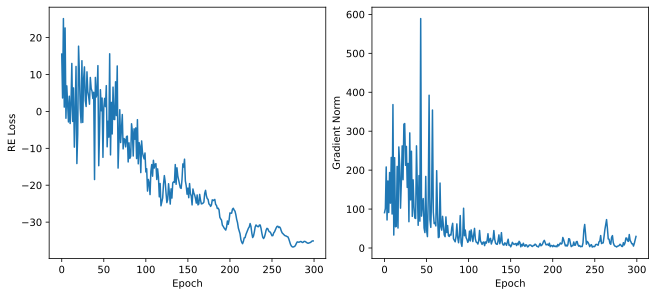

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

ax1.plot(relative_entropy.delta_re[0])
ax1.set_xticks(ticks=range(0, re_epochs + 1, 50))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RE Loss")

ax2.plot(relative_entropy.gradient_norm_history)
ax2.set_xticks(ticks=range(0, re_epochs + 1, 50))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Gradient Norm")

## Force Matching

For comparison, we also train a second instance of the potential model via FM.
Similar to REM, we only consider a subset of the data for training.
However, mainly to prevent overfitting, we need additional data for validation.
Hence, the part of data we can use for training is smaller.

In [14]:
fm_epochs = 150
fm_used_dataset_size = 500000
fm_train_ratio = 0.7
fm_val_ratio = 0.1
fm_batch_per_device = 512
fm_batch_cache = 50
fm_initial_lr = 0.001

lrd = int(fm_used_dataset_size / fm_batch_per_device * fm_epochs)
lr_schedule = optax.exponential_decay(fm_initial_lr, lrd, 0.01)
fm_optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0)
)

force_matching = trainers.ForceMatching(
    init_params, energy_fn_template, nbrs_init, fm_optimizer,
    position_data=position_dataset[:fm_used_dataset_size, ...],
    force_data=force_dataset[:fm_used_dataset_size, ...],
    batch_per_device=fm_batch_per_device,
    box_tensor=box_tensor,
    batch_cache=fm_batch_cache,
    train_ratio=fm_train_ratio
)

In [15]:
force_matching.train(150)

force_matching.save_energy_params("../_data/alanine_dipeptide_fm_params.pkl", '.pkl')
force_matching.save_trainer("../_data/alanine_dipeptide_fm_trainer.pkl", '.pkl')

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packag

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


Epoch 0: Average train loss: 175667.39062 Average val loss: 172602.03125 Gradient norm: 3568876544.0 Elapsed time = 2.790 min


Epoch 1: Average train loss: 172397.12500 Average val loss: 172277.90625 Gradient norm: 3207297792.0 Elapsed time = 1.608 min


Epoch 2: Average train loss: 172190.31250 Average val loss: 172266.140625 Gradient norm: 10150837248.0 Elapsed time = 1.625 min


Epoch 3: Average train loss: 172059.01562 Average val loss: 172584.421875 Gradient norm: 6425615360.0 Elapsed time = 1.620 min


Epoch 4: Average train loss: 172007.57812 Average val loss: 172292.8125 Gradient norm: 1149354880.0 Elapsed time = 1.611 min


Epoch 5: Average train loss: 171912.51562 Average val loss: 172016.640625 Gradient norm: 1610685312.0 Elapsed time = 1.622 min


Epoch 6: Average train loss: 171892.84375 Average val loss: 171959.515625 Gradient norm: 1759752832.0 Elapsed time = 1.616 min


Epoch 7: Average train loss: 171865.51562 Average val loss: 171993.25 Gradient norm: 1958092928.0 Elapsed time = 1.620 min


Epoch 8: Average train loss: 171821.18750 Average val loss: 171979.46875 Gradient norm: 1572643840.0 Elapsed time = 1.614 min


Epoch 9: Average train loss: 171777.39062 Average val loss: 171908.328125 Gradient norm: 5139713024.0 Elapsed time = 1.622 min


Epoch 10: Average train loss: 171757.18750 Average val loss: 172084.9375 Gradient norm: 11010505728.0 Elapsed time = 1.623 min


Epoch 11: Average train loss: 171746.87500 Average val loss: 171911.8125 Gradient norm: 3606072320.0 Elapsed time = 1.611 min


Epoch 12: Average train loss: 171742.07812 Average val loss: 171782.203125 Gradient norm: 484498784.0 Elapsed time = 1.614 min


Epoch 13: Average train loss: 171677.59375 Average val loss: 172000.359375 Gradient norm: 1270315904.0 Elapsed time = 1.624 min


Epoch 14: Average train loss: 171696.06250 Average val loss: 171891.046875 Gradient norm: 1054092672.0 Elapsed time = 1.607 min


Epoch 15: Average train loss: 171691.37500 Average val loss: 171856.59375 Gradient norm: 2013665792.0 Elapsed time = 1.616 min


Epoch 16: Average train loss: 171630.06250 Average val loss: 171855.25 Gradient norm: 1459498624.0 Elapsed time = 1.606 min


Epoch 17: Average train loss: 171656.06250 Average val loss: 171834.21875 Gradient norm: 390563008.0 Elapsed time = 1.600 min


Epoch 18: Average train loss: 171627.10938 Average val loss: 171760.5 Gradient norm: 394364416.0 Elapsed time = 1.607 min


Epoch 19: Average train loss: 171614.78125 Average val loss: 171814.71875 Gradient norm: 1068035328.0 Elapsed time = 1.612 min


Epoch 20: Average train loss: 171606.56250 Average val loss: 171948.4375 Gradient norm: 516810176.0 Elapsed time = 1.602 min


Epoch 21: Average train loss: 171609.73438 Average val loss: 171754.375 Gradient norm: 645742272.0 Elapsed time = 1.613 min


Epoch 22: Average train loss: 171588.09375 Average val loss: 171830.578125 Gradient norm: 456206432.0 Elapsed time = 1.603 min


Epoch 23: Average train loss: 171597.62500 Average val loss: 171847.875 Gradient norm: 203588336.0 Elapsed time = 1.622 min


Epoch 24: Average train loss: 171530.15625 Average val loss: 171823.25 Gradient norm: 318921536.0 Elapsed time = 1.616 min


Epoch 25: Average train loss: 171558.67188 Average val loss: 171872.921875 Gradient norm: 507512992.0 Elapsed time = 1.620 min


Epoch 26: Average train loss: 171519.12500 Average val loss: 171773.28125 Gradient norm: 1111328768.0 Elapsed time = 1.609 min


Epoch 27: Average train loss: 171569.65625 Average val loss: 171869.96875 Gradient norm: 854823424.0 Elapsed time = 1.620 min


Epoch 28: Average train loss: 171509.06250 Average val loss: 171741.609375 Gradient norm: 888632640.0 Elapsed time = 1.613 min


Epoch 29: Average train loss: 171515.21875 Average val loss: 171751.625 Gradient norm: 603906752.0 Elapsed time = 1.619 min


Epoch 30: Average train loss: 171520.76562 Average val loss: 171881.0 Gradient norm: 443866016.0 Elapsed time = 1.615 min


Epoch 31: Average train loss: 171510.15625 Average val loss: 171876.203125 Gradient norm: 756045120.0 Elapsed time = 1.622 min


Epoch 32: Average train loss: 171488.15625 Average val loss: 171766.15625 Gradient norm: 399251616.0 Elapsed time = 1.615 min


Epoch 33: Average train loss: 171471.00000 Average val loss: 171755.546875 Gradient norm: 760616512.0 Elapsed time = 1.623 min


Epoch 34: Average train loss: 171413.23438 Average val loss: 171860.125 Gradient norm: 2112595712.0 Elapsed time = 1.612 min


Epoch 35: Average train loss: 171508.09375 Average val loss: 171782.375 Gradient norm: 537473408.0 Elapsed time = 1.622 min


Epoch 36: Average train loss: 171489.09375 Average val loss: 171759.34375 Gradient norm: 133203976.0 Elapsed time = 1.611 min


Epoch 37: Average train loss: 171404.56250 Average val loss: 171810.375 Gradient norm: 502651968.0 Elapsed time = 1.624 min


Epoch 38: Average train loss: 171437.82812 Average val loss: 171725.78125 Gradient norm: 300276096.0 Elapsed time = 1.614 min


Epoch 39: Average train loss: 171488.06250 Average val loss: 171862.34375 Gradient norm: 476641312.0 Elapsed time = 1.628 min


Epoch 40: Average train loss: 171372.46875 Average val loss: 171772.796875 Gradient norm: 476720128.0 Elapsed time = 1.617 min


Epoch 41: Average train loss: 171397.87500 Average val loss: 171772.140625 Gradient norm: 927389248.0 Elapsed time = 1.621 min


Epoch 42: Average train loss: 171368.76562 Average val loss: 171804.796875 Gradient norm: 1210535552.0 Elapsed time = 1.610 min


Epoch 43: Average train loss: 171403.01562 Average val loss: 171764.71875 Gradient norm: 1657303040.0 Elapsed time = 1.623 min


Epoch 44: Average train loss: 171427.42188 Average val loss: 171811.09375 Gradient norm: 428743008.0 Elapsed time = 1.610 min


Epoch 45: Average train loss: 171334.90625 Average val loss: 171796.109375 Gradient norm: 1275842560.0 Elapsed time = 1.623 min


Epoch 46: Average train loss: 171373.48438 Average val loss: 171810.953125 Gradient norm: 738025216.0 Elapsed time = 1.612 min


Epoch 47: Average train loss: 171324.56250 Average val loss: 171787.25 Gradient norm: 334945248.0 Elapsed time = 1.618 min


Epoch 48: Average train loss: 171354.62500 Average val loss: 171814.921875 Gradient norm: 336552768.0 Elapsed time = 1.614 min


Epoch 49: Average train loss: 171300.06250 Average val loss: 171829.578125 Gradient norm: 206709184.0 Elapsed time = 1.624 min


Epoch 50: Average train loss: 171368.09375 Average val loss: 171890.8125 Gradient norm: 216355760.0 Elapsed time = 1.610 min


Epoch 51: Average train loss: 171286.04688 Average val loss: 171822.78125 Gradient norm: 678687808.0 Elapsed time = 1.620 min


Epoch 52: Average train loss: 171271.35938 Average val loss: 171904.734375 Gradient norm: 969322176.0 Elapsed time = 1.611 min


Epoch 53: Average train loss: 171284.48438 Average val loss: 171827.984375 Gradient norm: 319749216.0 Elapsed time = 1.622 min


Epoch 54: Average train loss: 171296.10938 Average val loss: 171857.15625 Gradient norm: 565542720.0 Elapsed time = 1.611 min


Epoch 55: Average train loss: 171261.00000 Average val loss: 171847.890625 Gradient norm: 909014080.0 Elapsed time = 1.625 min


Epoch 56: Average train loss: 171208.03125 Average val loss: 171839.890625 Gradient norm: 907107712.0 Elapsed time = 1.610 min


Epoch 57: Average train loss: 171266.14062 Average val loss: 171845.3125 Gradient norm: 1015046592.0 Elapsed time = 1.621 min


Epoch 58: Average train loss: 171172.10938 Average val loss: 171859.1875 Gradient norm: 483813984.0 Elapsed time = 1.611 min


Epoch 59: Average train loss: 171252.09375 Average val loss: 171872.65625 Gradient norm: 213133968.0 Elapsed time = 1.625 min


Epoch 60: Average train loss: 171166.32812 Average val loss: 171874.0625 Gradient norm: 682095104.0 Elapsed time = 1.613 min


Epoch 61: Average train loss: 171198.39062 Average val loss: 171917.78125 Gradient norm: 434415008.0 Elapsed time = 1.622 min


Epoch 62: Average train loss: 171147.29688 Average val loss: 171897.765625 Gradient norm: 226488016.0 Elapsed time = 1.613 min


Epoch 63: Average train loss: 171145.07812 Average val loss: 171871.4375 Gradient norm: 397887456.0 Elapsed time = 1.621 min


Epoch 64: Average train loss: 171147.10938 Average val loss: 171949.734375 Gradient norm: 732690752.0 Elapsed time = 1.612 min


Epoch 65: Average train loss: 171067.85938 Average val loss: 171905.8125 Gradient norm: 669476480.0 Elapsed time = 1.623 min


Epoch 66: Average train loss: 171115.51562 Average val loss: 171915.328125 Gradient norm: 279886048.0 Elapsed time = 1.611 min


Epoch 67: Average train loss: 171053.95312 Average val loss: 171940.28125 Gradient norm: 1080761600.0 Elapsed time = 1.625 min


Epoch 68: Average train loss: 171095.14062 Average val loss: 171980.265625 Gradient norm: 328893344.0 Elapsed time = 1.611 min


Epoch 69: Average train loss: 171077.87500 Average val loss: 171955.875 Gradient norm: 670225856.0 Elapsed time = 1.626 min


Epoch 70: Average train loss: 171007.26562 Average val loss: 171996.328125 Gradient norm: 641905920.0 Elapsed time = 1.613 min


Epoch 71: Average train loss: 170981.10938 Average val loss: 171965.921875 Gradient norm: 309486624.0 Elapsed time = 1.628 min


Epoch 72: Average train loss: 171041.17188 Average val loss: 172022.609375 Gradient norm: 775496512.0 Elapsed time = 1.612 min


Epoch 73: Average train loss: 170957.26562 Average val loss: 171974.203125 Gradient norm: 470850496.0 Elapsed time = 1.628 min


Epoch 74: Average train loss: 171044.06250 Average val loss: 172056.65625 Gradient norm: 879217344.0 Elapsed time = 1.614 min


Epoch 75: Average train loss: 170922.59375 Average val loss: 172035.3125 Gradient norm: 414414656.0 Elapsed time = 1.623 min


Epoch 76: Average train loss: 170936.23438 Average val loss: 172064.484375 Gradient norm: 720899520.0 Elapsed time = 1.610 min


Epoch 77: Average train loss: 170950.00000 Average val loss: 172056.78125 Gradient norm: 429372928.0 Elapsed time = 1.626 min


Epoch 78: Average train loss: 170891.25000 Average val loss: 172169.5625 Gradient norm: 1241142400.0 Elapsed time = 1.610 min


Epoch 79: Average train loss: 170944.04688 Average val loss: 172073.84375 Gradient norm: 1312076160.0 Elapsed time = 1.620 min


Epoch 80: Average train loss: 170830.62500 Average val loss: 172065.6875 Gradient norm: 416471072.0 Elapsed time = 1.611 min


Epoch 81: Average train loss: 170862.78125 Average val loss: 172113.65625 Gradient norm: 732946688.0 Elapsed time = 1.622 min


Epoch 82: Average train loss: 170849.90625 Average val loss: 172130.21875 Gradient norm: 652293120.0 Elapsed time = 1.613 min


Epoch 83: Average train loss: 170830.85938 Average val loss: 172132.296875 Gradient norm: 496275328.0 Elapsed time = 1.627 min


Epoch 84: Average train loss: 170800.64062 Average val loss: 172171.296875 Gradient norm: 739542144.0 Elapsed time = 1.611 min


Epoch 85: Average train loss: 170874.21875 Average val loss: 172146.921875 Gradient norm: 1069208256.0 Elapsed time = 1.626 min


Epoch 86: Average train loss: 170731.98438 Average val loss: 172162.890625 Gradient norm: 1507456384.0 Elapsed time = 1.613 min


Epoch 87: Average train loss: 170751.09375 Average val loss: 172157.09375 Gradient norm: 1061403392.0 Elapsed time = 1.624 min


Epoch 88: Average train loss: 170782.45312 Average val loss: 172201.078125 Gradient norm: 681578560.0 Elapsed time = 1.615 min


Epoch 89: Average train loss: 170758.68750 Average val loss: 172204.84375 Gradient norm: 570237760.0 Elapsed time = 1.625 min


Epoch 90: Average train loss: 170724.04688 Average val loss: 172274.671875 Gradient norm: 1044795776.0 Elapsed time = 1.612 min


Epoch 91: Average train loss: 170640.84375 Average val loss: 172246.890625 Gradient norm: 850221120.0 Elapsed time = 1.624 min


Epoch 92: Average train loss: 170684.89062 Average val loss: 172241.625 Gradient norm: 526376576.0 Elapsed time = 1.614 min


Epoch 93: Average train loss: 170696.10938 Average val loss: 172258.703125 Gradient norm: 1114332672.0 Elapsed time = 1.623 min


Epoch 94: Average train loss: 170616.50000 Average val loss: 172309.765625 Gradient norm: 879636352.0 Elapsed time = 1.613 min


Epoch 95: Average train loss: 170685.78125 Average val loss: 172335.765625 Gradient norm: 976117952.0 Elapsed time = 1.627 min


Epoch 96: Average train loss: 170590.89062 Average val loss: 172290.875 Gradient norm: 645065984.0 Elapsed time = 1.611 min


Epoch 97: Average train loss: 170657.56250 Average val loss: 172324.4375 Gradient norm: 921586688.0 Elapsed time = 1.623 min


Epoch 98: Average train loss: 170536.12500 Average val loss: 172332.96875 Gradient norm: 938669440.0 Elapsed time = 1.615 min


Epoch 99: Average train loss: 170703.60938 Average val loss: 172380.546875 Gradient norm: 871277120.0 Elapsed time = 1.622 min


Epoch 100: Average train loss: 170464.31250 Average val loss: 172377.40625 Gradient norm: 1313836160.0 Elapsed time = 1.610 min


Epoch 101: Average train loss: 170580.32812 Average val loss: 172375.140625 Gradient norm: 808480384.0 Elapsed time = 1.628 min


Epoch 102: Average train loss: 170481.37500 Average val loss: 172401.671875 Gradient norm: 750998336.0 Elapsed time = 1.613 min


Epoch 103: Average train loss: 170566.73438 Average val loss: 172391.71875 Gradient norm: 856824448.0 Elapsed time = 1.629 min


Epoch 104: Average train loss: 170548.32812 Average val loss: 172426.640625 Gradient norm: 870148480.0 Elapsed time = 1.610 min


Epoch 105: Average train loss: 170415.89062 Average val loss: 172431.734375 Gradient norm: 1340631296.0 Elapsed time = 1.626 min


Epoch 106: Average train loss: 170540.65625 Average val loss: 172406.171875 Gradient norm: 1137946880.0 Elapsed time = 1.612 min


Epoch 107: Average train loss: 170521.65625 Average val loss: 172462.609375 Gradient norm: 1179877504.0 Elapsed time = 1.628 min


Epoch 108: Average train loss: 170366.23438 Average val loss: 172487.5625 Gradient norm: 972505280.0 Elapsed time = 1.614 min


Epoch 109: Average train loss: 170454.09375 Average val loss: 172458.9375 Gradient norm: 1003179264.0 Elapsed time = 1.626 min


Epoch 110: Average train loss: 170452.60938 Average val loss: 172482.515625 Gradient norm: 838971200.0 Elapsed time = 1.609 min


Epoch 111: Average train loss: 170413.26562 Average val loss: 172481.21875 Gradient norm: 1519760896.0 Elapsed time = 1.624 min


Epoch 112: Average train loss: 170420.64062 Average val loss: 172489.703125 Gradient norm: 1002589440.0 Elapsed time = 1.617 min


Epoch 113: Average train loss: 170344.31250 Average val loss: 172520.5 Gradient norm: 777977920.0 Elapsed time = 1.614 min


Epoch 114: Average train loss: 170439.73438 Average val loss: 172524.46875 Gradient norm: 1377001472.0 Elapsed time = 1.624 min


Epoch 115: Average train loss: 170406.04688 Average val loss: 172536.3125 Gradient norm: 1204902144.0 Elapsed time = 1.618 min


Epoch 116: Average train loss: 170282.59375 Average val loss: 172528.3125 Gradient norm: 1133485056.0 Elapsed time = 1.626 min


Epoch 117: Average train loss: 170312.34375 Average val loss: 172552.234375 Gradient norm: 1675698560.0 Elapsed time = 1.613 min


Epoch 118: Average train loss: 170304.23438 Average val loss: 172553.046875 Gradient norm: 1417412352.0 Elapsed time = 1.615 min


Epoch 119: Average train loss: 170434.76562 Average val loss: 172577.75 Gradient norm: 1586141952.0 Elapsed time = 1.626 min


Epoch 120: Average train loss: 170303.95312 Average val loss: 172596.859375 Gradient norm: 1377595904.0 Elapsed time = 1.610 min


Epoch 121: Average train loss: 170316.04688 Average val loss: 172608.1875 Gradient norm: 1215222400.0 Elapsed time = 1.627 min


Epoch 122: Average train loss: 170212.81250 Average val loss: 172656.25 Gradient norm: 1419388928.0 Elapsed time = 1.615 min


Epoch 123: Average train loss: 170356.54688 Average val loss: 172632.796875 Gradient norm: 2111200384.0 Elapsed time = 1.627 min


Epoch 124: Average train loss: 170174.35938 Average val loss: 172596.671875 Gradient norm: 1446210304.0 Elapsed time = 1.614 min


Epoch 125: Average train loss: 170279.92188 Average val loss: 172630.25 Gradient norm: 1872879616.0 Elapsed time = 1.629 min


Epoch 126: Average train loss: 170241.71875 Average val loss: 172644.53125 Gradient norm: 1009642624.0 Elapsed time = 1.611 min


Epoch 127: Average train loss: 170265.59375 Average val loss: 172632.109375 Gradient norm: 1907457792.0 Elapsed time = 1.610 min


Epoch 128: Average train loss: 170235.15625 Average val loss: 172655.25 Gradient norm: 1771360640.0 Elapsed time = 1.627 min


Epoch 129: Average train loss: 170115.21875 Average val loss: 172690.109375 Gradient norm: 1115274880.0 Elapsed time = 1.613 min


Epoch 130: Average train loss: 170299.14062 Average val loss: 172711.28125 Gradient norm: 1256705536.0 Elapsed time = 1.629 min


Epoch 131: Average train loss: 170240.35938 Average val loss: 172702.796875 Gradient norm: 1253538816.0 Elapsed time = 1.608 min


Epoch 132: Average train loss: 170119.46875 Average val loss: 172719.5 Gradient norm: 1238543744.0 Elapsed time = 1.632 min


Epoch 133: Average train loss: 170162.07812 Average val loss: 172734.671875 Gradient norm: 1609226368.0 Elapsed time = 1.613 min


Epoch 134: Average train loss: 170187.17188 Average val loss: 172737.265625 Gradient norm: 1297078272.0 Elapsed time = 1.613 min


Epoch 135: Average train loss: 170202.48438 Average val loss: 172717.53125 Gradient norm: 1201873280.0 Elapsed time = 1.626 min


Epoch 136: Average train loss: 170150.85938 Average val loss: 172748.53125 Gradient norm: 1685131392.0 Elapsed time = 1.611 min


Epoch 137: Average train loss: 170114.50000 Average val loss: 172732.234375 Gradient norm: 1201450624.0 Elapsed time = 1.625 min


Epoch 138: Average train loss: 170096.20312 Average val loss: 172737.40625 Gradient norm: 1744227840.0 Elapsed time = 1.612 min


Epoch 139: Average train loss: 170116.73438 Average val loss: 172748.59375 Gradient norm: 1226502144.0 Elapsed time = 1.617 min


Epoch 140: Average train loss: 170159.48438 Average val loss: 172737.5 Gradient norm: 1183467648.0 Elapsed time = 1.630 min


Epoch 141: Average train loss: 170085.78125 Average val loss: 172801.375 Gradient norm: 1521509248.0 Elapsed time = 1.608 min


Epoch 142: Average train loss: 170130.79688 Average val loss: 172800.640625 Gradient norm: 1694835072.0 Elapsed time = 1.626 min


Epoch 143: Average train loss: 170103.56250 Average val loss: 172810.03125 Gradient norm: 1669969024.0 Elapsed time = 1.611 min


Epoch 144: Average train loss: 170002.98438 Average val loss: 172827.609375 Gradient norm: 2062248576.0 Elapsed time = 1.630 min


Epoch 145: Average train loss: 170118.20312 Average val loss: 172824.328125 Gradient norm: 1870940928.0 Elapsed time = 1.614 min


Epoch 146: Average train loss: 170026.78125 Average val loss: 172826.953125 Gradient norm: 2261871104.0 Elapsed time = 1.626 min


Epoch 147: Average train loss: 170171.45312 Average val loss: 172839.609375 Gradient norm: 1661020672.0 Elapsed time = 1.611 min


Epoch 148: Average train loss: 170002.92188 Average val loss: 172812.40625 Gradient norm: 2033719424.0 Elapsed time = 1.629 min


Epoch 149: Average train loss: 170063.23438 Average val loss: 172847.25 Gradient norm: 1244370048.0 Elapsed time = 1.613 min


Plotting the training and validation loss indicates convergence after approximately $25$ epochs.
However, further training leads to overfitting of the potential model.
Therefore, the FM trainer keeps track of the parametrization with the lowest validation loss.

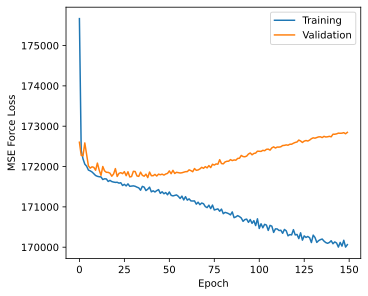

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout="constrained")
ax.plot(force_matching.train_losses, label="Training")
ax.plot(force_matching.val_losses, label="Validation")
ax.set_xticks(ticks=range(0, fm_epochs + 1, 25))
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Force Loss")
ax.legend()

## Evaluation

With both trained models, we perform a series of simulations to evaluate the alignment of both models with the reference data.
To reduce the total running time, we again run $100$ shorter simulations, which
still correspond to a total time of $100~\text{ns}$.

In [17]:
eval_total_time = 1100.
eval_t_eq = 100.
eval_t_sample = .5

eval_timings = traj_util.process_printouts(
    time_step=dt, total_time=eval_total_time,
    t_equilib=eval_t_eq, print_every=eval_t_sample
)

trajectory_generator = traj_util.trajectory_generator_init(
    sim_template, energy_fn_template, eval_timings)

In [18]:
t_start = time.time()
re_traj_state = trajectory_generator(relative_entropy.params, reference_state, **state_kwargs)
t_end = time.time() - t_start
print('total runtime:', t_end)

assert not re_traj_state.overflow, (
    'Neighborlist overflow during trajectory generation. '
    'Increase capacity and re-run.'
)

Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(200000, 10, 3), momentum=(200000, 10, 3), force=(200000, 10, 3), mass=(200000, 10, 1), rng=(200000, 2)), overflow=(), thermostat_kbt=(200000,), barostat_press=None, aux=None, key=None, energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embeddin

total runtime: 5799.555821895599


In [19]:
t_start = time.time()
fm_traj_state = trajectory_generator(force_matching.best_inference_params, reference_state, **state_kwargs)
t_end = time.time() - t_start
print('total runtime:', t_end)

assert not fm_traj_state.overflow, (
    'Neighborlist overflow during trajectory generation. '
    'Increase capacity and re-run.'
)

Traj states in beginning of multimap
(TrajectoryState(sim_state=(NVTLangevinState(position=(100, 10, 3), momentum=(100, 10, 3), force=(100, 10, 3), mass=(100, 10, 1), rng=(100, 2)), NeighborList(idx=(100, 10, 9), reference_position=(100, 10, 3), error=Error code not available (any requires ndarray or scalar arguments, got <class 'tuple'> at position 0.), cell_list_capacity=None, max_occupancy=9, format=<NeighborListFormat.Dense: 0>, cell_size=None, cell_list_fn=None, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7f42745f4e50>)), trajectory=NVTLangevinState(position=(200000, 10, 3), momentum=(200000, 10, 3), force=(200000, 10, 3), mass=(200000, 10, 1), rng=(200000, 2)), overflow=(), thermostat_kbt=(200000,), barostat_press=None, aux=None, key=None, energy_params={'DimeNetPP/~/BesselRadial': {'RBF_Frequencies': (6,)}, 'DimeNetPP/~/Embedding': {'Embedding_vect': (5, 16)}, 'DimeNetPP/~/Embedding/~/Concat_Dense/~/linear': {'b': (32,), 'w': (64, 32)}, 'DimeNetPP/~/Embeddin

total runtime: 5791.817906141281


In [20]:
def postprocess_fn(positions):
    # Compute the dihedral angles
    dihedral_idxs = jnp.array([[1, 3, 4, 6], [3, 4, 6, 8]])  # 0: phi    1: psi
    batched_dihedrals = jax.vmap(
        custom_quantity.dihedral_displacement, (0, None, None)
    )
    
    dihedral_angles = batched_dihedrals(positions, displacement_fn, dihedral_idxs)
    
    return dihedral_angles.T

ref_phi, ref_psi = postprocess_fn(position_dataset)
fm_phi, fm_psi = postprocess_fn(fm_traj_state.trajectory.position)
re_phi, re_psi = postprocess_fn(re_traj_state.trajectory.position)

In [21]:
def plot_1d_dihedral(ax, angles, labels, bins=60, degrees=True,
                     xlabel='$\phi$ in deg'):
    """Plot  1D histogram splines for a dihedral angle. """
    color = ['k', '#00A087FF', '#3C5488FF']
    line = ['--', '-', '-']
    
    n_models = len(angles)
    for i in range(n_models):
        if degrees:
            angles_conv = angles[i]
            hist_range = [-180, 180]
        else:
            angles_conv = onp.rad2deg(angles[i])
            hist_range = [-onp.pi, onp.pi]

        # Compute the histogram
        hist, x_bins = jnp.histogram(angles_conv, bins=bins, density=True, range=hist_range)
        width = x_bins[1] - x_bins[0]
        bin_center = x_bins + width / 2
        
        ax.plot(
            bin_center[:-1], hist, label=labels[i], color=color[i],
            linestyle=line[i], linewidth=2.0
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    
    return ax

def plot_histogram_free_energy(ax, phi, psi, kbt, degrees=True, title=""):
    """Plot 2D free energy histogram for alanine from the dihedral angles."""
    cmap = plt.get_cmap('magma')

    if degrees:
        phi = jnp.deg2rad(phi)
        psi = jnp.deg2rad(psi)

    h, x_edges, y_edges = jnp.histogram2d(phi, psi, bins=60, density=True)

    h = jnp.log(h) * -(kbt / 4.184)
    x, y = onp.meshgrid(x_edges, y_edges)

    cax = ax.pcolormesh(x, y, h.T, cmap=cmap, vmax=5.25)
    ax.set_xlabel('$\phi$ in rad')
    ax.set_ylabel('$\psi$ in rad')
    ax.set_title(title)
    
    return ax, cax
    

Plotting the dihedral angle distributions reveals that both FM and REM-trained models can identify the preferred torsional states of alanine-dipeptide.
However, the REM model reproduces the relative preference between the states much better.

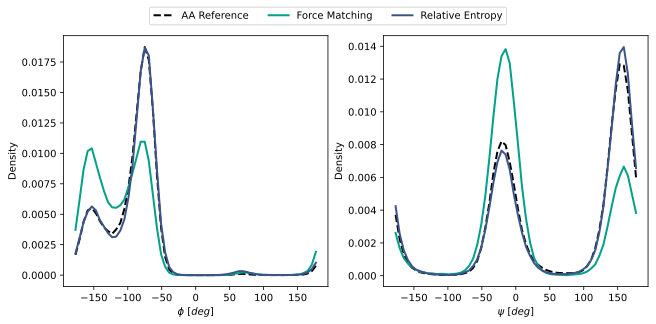

In [22]:
labels = ["AA Reference", "Force Matching", "Relative Entropy"]

fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(9, 4))
ax1 = plot_1d_dihedral(ax1, [ref_phi, fm_phi, re_phi], labels, xlabel="$\phi\ [deg]$")
ax2 = plot_1d_dihedral(ax2, [ref_psi, fm_psi, re_psi], labels, xlabel="$\psi\ [deg]$")
fig.legend(labels, ncols=len(labels), bbox_to_anchor=(0.5, 1.01), loc="lower center")

fig.savefig("../_data/alanine_dipeptide_1D_dihedral_angles.pdf")

Plotting the free energy surface of the backbone dihedral angles indicates similar results.
Both models can identify the regions of low free energy.
However, only the REM model correctly predicts the depth of these regions.

In [23]:
labels = ["AA Reference"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout="constrained", figsize=(9, 3))
ax1, _ = plot_histogram_free_energy(ax1, ref_phi, ref_psi, kT, title="AA Reference")
ax2, _ = plot_histogram_free_energy(ax2, fm_phi, fm_psi, kT, title="Force Matching")
ax3, cax = plot_histogram_free_energy(ax3, re_phi, re_psi, kT, title="Relative Entropy")

cbar = fig.colorbar(cax)
cbar.set_label('Free Energy (kcal/mol)')

fig.savefig("../_data/alanine_dipeptide_free_energy_dihedral_angles.pdf")

## References


[^Thaler2022]: Stephan Thaler, Maximilian Stupp, Julija Zavadlav; *Deep coarse-grained potentials via relative entropy minimization*. J. Chem. Phys. 28 December 2022; 157 (24): 244103. <https://doi.org/10.1063/5.0124538>
[^Feig2008]: Feig, M. Is Alanine Dipeptide a Good Model for Representing the Torsional Preferences of Protein Backbones? _J. Chem. Theory Comput._ **2008**, _4_ (9), 1555–1564. [https://doi.org/10.1021/ct800153n](https://doi.org/10.1021/ct800153n).
[^DimeNet]: Gasteiger, J.; Giri, S.; Margraf, J. T.; Günnemann, S. _Fast and Uncertainty-Aware Directional Message Passing for Non-Equilibrium Molecules_. [http://arxiv.org/abs/2011.14115](http://arxiv.org/abs/2011.14115) (accessed 2023-06-29).
[^Duan2003]: Duan, Y.; Wu, C.; Chowdhury, S.; Lee, M. C.; Xiong, G.; Zhang, W.; Yang, R.; Cieplak, P.; Luo, R.; Lee, T.; Caldwell, J.; Wang, J.; Kollman, P. A Point‐charge Force Field for Molecular Mechanics Simulations of Proteins Based on Condensed‐phase Quantum Mechanical Calculations. _J Comput Chem_ **2003**, _24_ (16), 1999–2012. [https://doi.org/10.1002/jcc.10349](https://doi.org/10.1002/jcc.10349).
[^Tildesley2017]: Allen, M. P.; Tildesley, D. J. _Computer Simulation of Liquids_; Oxford University Press, 2017. [https://doi.org/10.1093/oso/9780198803195.001.0001](https://doi.org/10.1093/oso/9780198803195.001.0001).
[^McGibbon2015]: McGibbon, R. T.; Beauchamp, K. A.; Harrigan, M. P.; Klein, C.; Swails, J. M.; Hernández, C. X.; Schwantes, C. R.; Wang, L.-P.; Lane, T. J.; Pande, V. S. MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. _Biophys J_ **2015**, _109_ (8), 1528–1532. [https://doi.org/10.1016/j.bpj.2015.08.015](https://doi.org/10.1016/j.bpj.2015.08.015).